In [55]:
!pip install jsonlines pandas matplotlib nltk

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import jsonlines
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import os

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Carga del dataset

In [5]:
path_test = r'./dataset/test_diplomacy.jsonl'
path_train = r'./dataset/train_diplomacy.jsonl'
path_validation = r'./dataset/validation_diplomacy.jsonl'

In [6]:
def load_data(dataset):
    with jsonlines.open(dataset, 'r') as reader:
        data = list(reader)
        list_messages = []
        list_labels = []
        for line in data:
            list_messages.extend(line['messages'])
            list_labels.extend(line['sender_labels'])
    dict_out = {'messages': list_messages, 'label': list_labels}
    df = pd.DataFrame(dict_out)
    return df

In [7]:
%cd   /content/drive/MyDrive/prueba_tenica_BC/
!ls

/content/drive/MyDrive/prueba_tenica_BC
dataset  EDA.ipynb  model_train  train_model.ipynb


In [8]:
!pwd

/content/drive/MyDrive/prueba_tenica_BC


In [9]:
test=load_data(path_test)
train = load_data(path_train)
validation = load_data(path_validation)

### validar nulos en el Dataset

In [10]:
na_test = test[test.isna().any(axis=1)]
na_train = train[train.isna().any(axis=1)]
na_vali = validation[validation.isna().any(axis=1)]

print("cantidad de datos vacios de entrenamiento" ,na_train.shape[0])
print("cantidad de datos vacios de validacion" ,na_vali.shape[0])
print("cantidad de datos vacios de test" ,na_test.shape[0])

cantidad de datos vacios de entrenamiento 0
cantidad de datos vacios de validacion 0
cantidad de datos vacios de test 0


### Gráfica de barras de la variable objetivo

- Esto se realiza para cada conjunto de datos

<ipython-input-11-8bdc81c57a69>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=train, ax= axes [0] ,palette='Set1')
<ipython-input-11-8bdc81c57a69>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=validation, ax= axes [1] ,palette='Set2')
<ipython-input-11-8bdc81c57a69>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=test, ax= axes [2] ,palette='Set3')


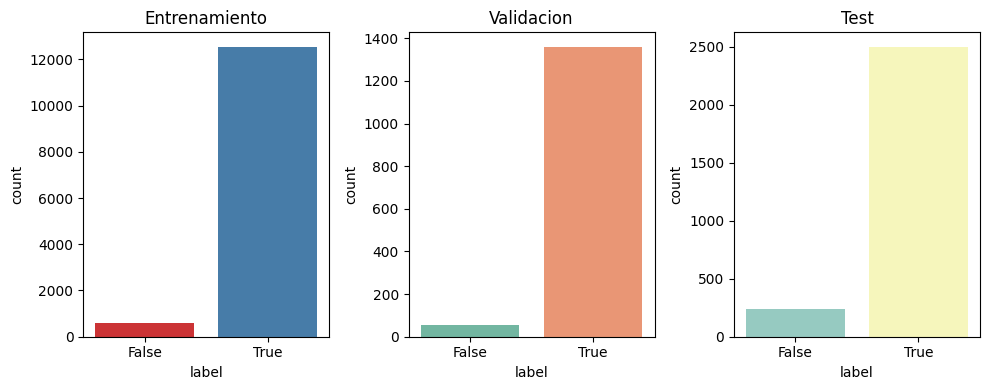

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

sns.countplot(x='label', data=train, ax= axes [0] ,palette='Set1')
sns.countplot(x='label', data=validation, ax= axes [1] ,palette='Set2')
sns.countplot(x='label', data=test, ax= axes [2] ,palette='Set3')

axes[0].set_title("Entrenamiento")
axes[1].set_title("Validacion")
axes[2].set_title("Test")

plt.tight_layout()
plt.show()

### Limpieza de stopwords

In [12]:
def clean_text(t):
    tl = []
    t = t.lower().split()
    for i in t:
        if i not in stopwords.words('english'):
            tl.append(i)
    return " ".join(tl)

In [13]:
def all_clean(dataset, column):
    dataset[column] = dataset[column].apply((lambda x:re.sub('@[^\s]+','',x)))
    dataset[column] = dataset[column].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
    text1 = dataset[column].apply(lambda x: clean_text(x))
    return text1

### *validación de longitud para conjunto de train*

In [14]:
train_false= train[train['label']==False]
train_true= train[train['label']==True]

In [15]:
serie_true = all_clean(train_true,'messages')
serie_false = all_clean(train_false,'messages')

<ipython-input-13-3ee8878a2006>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column] = dataset[column].apply((lambda x:re.sub('@[^\s]+','',x)))
<ipython-input-13-3ee8878a2006>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[column] = dataset[column].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
<ipython-input-13-3ee8878a2006>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [ ]:
dim_true = serie_true.str.split().str.len()
dim_false = serie_false.str.split().str.len()

In [16]:
dim_true = train_true['messages'].str.split().str.len()
dim_false = train_false['messages'].str.split().str.len()

#### Anáilisis de las Verdades (True)

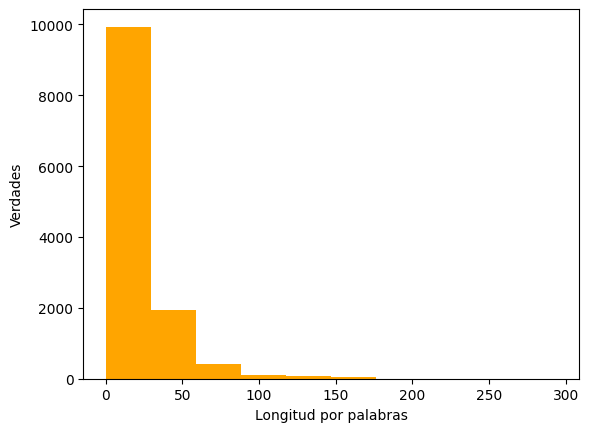

In [17]:
fig, ax1 = plt.subplots()
plt.hist(dim_true,color='orange')
ax1.set_xlabel('Longitud por palabras'), ax1.set_ylabel("Verdades")
plt.show()

In [18]:
dim_true.describe()

count    12541.000000
mean        20.229328
std         21.680378
min          0.000000
25%          7.000000
50%         14.000000
75%         26.000000
max        294.000000
Name: messages, dtype: float64

#### Anáilisis de las mentiras (False)

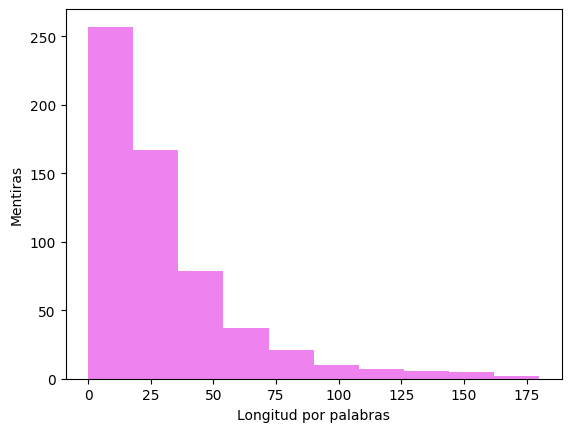

In [19]:
fig, ax1 = plt.subplots()
plt.hist(dim_false,color='violet')
ax1.set_xlabel('Longitud por palabras'), ax1.set_ylabel("Mentiras")
plt.show()

In [20]:
dim_false.describe()

count    591.000000
mean      29.822335
std       29.268203
min        0.000000
25%       10.000000
50%       20.000000
75%       40.000000
max      180.000000
Name: messages, dtype: float64

In [23]:
dim_true[dim_true>25].shape

(3229,)

### Conjunto de test

In [24]:
test_false= test[test['label']==False]
test_true= test[test['label']==True]

In [25]:
print(f'la longitud de las mentiras es: {test_false.shape[0]}')
print(f'la longitud de las verdades es: {test_true.shape[0]}')

la longitud de las mentiras es: 240
la longitud de las verdades es: 2501


In [26]:
dim_true_test = test_true['messages'].str.split().str.len()
dim_false_test = test_false['messages'].str.split().str.len()

#### Anáilisis de las Verdades (True)

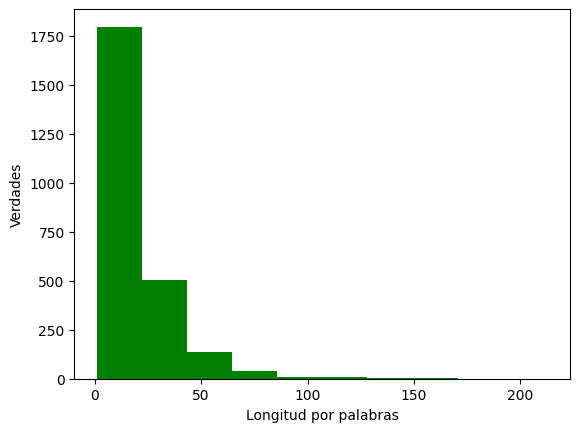

In [27]:
fig, ax1 = plt.subplots()
plt.hist(dim_true_test,color='green')
ax1.set_xlabel('Longitud por palabras'), ax1.set_ylabel("Verdades")
plt.show()

In [28]:
dim_true_test.describe()

count    2501.000000
mean       18.396641
std        18.369655
min         1.000000
25%         6.000000
50%        13.000000
75%        25.000000
max       213.000000
Name: messages, dtype: float64

#### Análisis de las mentiras (False)

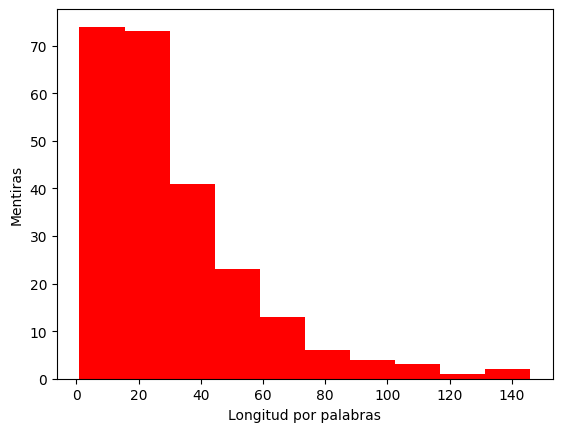

In [30]:
fig, ax1 = plt.subplots()
plt.hist(dim_false_test,color='red')
ax1.set_xlabel('Longitud por palabras'), ax1.set_ylabel("Mentiras")
plt.show()

In [29]:
dim_false_test.describe()

count    240.000000
mean      30.520833
std       25.726588
min        1.000000
25%       12.000000
50%       24.000000
75%       41.000000
max      146.000000
Name: messages, dtype: float64

In [ ]:
dim_true_test[dim_true_test > 25].shape[0]

601